In [1]:
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import torch 
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import time
import copy
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
# Transformation
MEAN_NUMS = [0.485, 0.456, 0.406]
STD_NUMS = [0.229, 0.224, 0.225]

chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(MEAN_NUMS, STD_NUMS)
]), 'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(MEAN_NUMS, STD_NUMS)
]), 'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(MEAN_NUMS, STD_NUMS)
]),
}

In [3]:
# Create datasets for train, valid, test
DATA_DIR = '../data/'
chosen_datasets = {
    x: datasets.ImageFolder(os.path.join(DATA_DIR, x), chosen_transforms[x]) 
    for x in ['train', 'valid', 'test']
}

In [4]:
# Make iterables with the dataloaders
dataloaders = {
    x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size=4, shuffle=True, num_workers=0)
    for x in ['train', 'valid', 'test']
}

In [5]:
dataset_sizes = {x: len(chosen_datasets[x]) for x in ['train', 'valid', 'test']}
CLASS_NAMES = chosen_datasets['train'].classes
CLASS_COUNTER = len(CLASS_NAMES)
print('Class Counter: {}'.format(CLASS_COUNTER))
print('Class Names: {}'.format(CLASS_NAMES))

Class Counter: 7
Class Names: ['CAT', 'COW', 'DEER', 'FOX', 'HORSE', 'SQUIRREL', 'WOLF']


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cuda


In [7]:
# Visualize 1 image per class
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([MEAN_NUMS])
    std = np.array([STD_NUMS])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

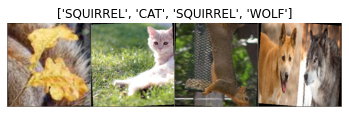

In [8]:
# Show Training Data
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[CLASS_NAMES[x] for x in classes])

In [9]:
# Save Metrics
accuracy_Scores = []
losses = []
f1_Scores = []
precision_Scores = []
recall_Scores = []

In [10]:
def train_model(model, model_name, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  
            elif phase == 'valid':
                model.eval()   

            running_loss, running_corrects, running_f1, running_precision, running_recall = 0.0, 0.0, 0.0, 0.0, 0.0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)                
                
                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # Statistics                
                running_corrects += torch.sum(preds.cpu() == labels.cpu().data).double()
                running_loss += loss.item() * inputs.size(0)                                                                        
                running_f1 += f1_score(labels.cpu().data, preds.cpu(), average='weighted')                                          
                running_precision += precision_score(labels.cpu().data, preds.cpu(), average='weighted', labels=np.unique(preds.cpu()))              
                running_recall += recall_score(labels.cpu().data, preds.cpu(), average='weighted', zero_division=0)            

            epoch_acc = running_corrects / dataset_sizes[phase] 
            epoch_loss = running_loss / dataset_sizes[phase]                       
            epoch_f1 = running_f1 / dataset_sizes[phase]
            epoch_precision = running_precision / dataset_sizes[phase]
            epoch_recall = running_recall / dataset_sizes[phase] 
                       
            if phase == 'train':
                scheduler.step()            
                accuracy_Scores.append(epoch_acc)
                losses.append(epoch_loss)    
                f1_Scores.append(epoch_f1) 
                precision_Scores.append(epoch_precision)
                recall_Scores.append(epoch_recall)
            
            print('[{}] Loss: {:.4f} Acc: {:.4f} F1-Score: {:.4f} Precision: {:.4f} Recall: {:.4f}'.format(
                phase.upper(), epoch_loss, epoch_acc, epoch_f1, epoch_precision, epoch_recall))

            # Deep copy the model
            if phase == 'valid':
                torch.save(model , model_name+'weights.pt')
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    # Load the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for phase in ['valid']:  
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                for j in range(inputs.size()[0]):
                    images_handeled += 1
                    ax = plt.subplot(1, num_images, 1)
                    ax.axis('off')
                    ax.set_title('Predicted: {}'.format(CLASS_NAMES[preds[j]]))
                    imshow(inputs.cpu().data[j])

                    if images_handeled == num_images:
                        model.train(mode=was_training)
                        return
        model.train(mode=was_training)

In [12]:
def test_model(model, criterion):   
    since = time.time()   
    running_accuracy, running_loss, running_f1, running_precision, running_recall = 0.0, 0.0, 0.0, 0.0, 0.0
 
    with torch.no_grad():         
        for phase in ['test']:            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)                
            
                outputs = model(inputs)             
                _, preds = torch.max(outputs, 1) 
                loss = criterion(outputs, labels)
                
                running_accuracy += torch.sum(preds.cpu() == labels.cpu().data).double()
                running_loss += loss.item() * inputs.size(0)
                running_f1 += f1_score(labels.cpu().data, preds.cpu(), average='weighted')
                running_precision += precision_score(labels.cpu().data, preds.cpu(), average='weighted', labels=np.unique(preds.cpu()))   
                running_recall += recall_score(labels.cpu().data, preds.cpu(), average='weighted', zero_division=0) 
          
        acc = running_accuracy / dataset_sizes[phase]
        loss = running_loss / dataset_sizes[phase]
        f1 = running_f1 / dataset_sizes[phase]
        precision =  running_precision / dataset_sizes[phase]
        recall = running_recall / dataset_sizes[phase]
        
        print('[{}] Loss: {:.4f} Acc: {:.4f} F1-Score: {:.4f} Precision: {:.4f} Recall: {:.4f}'.format(
            phase.upper(), loss, acc, f1, precision, recall))
        
    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))